# Question 1: Plot Daily Sales for All 50 Weeks

In [66]:
# Import dependencies
import os
import glob
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

In [67]:
# Get all file names in datasets directory
all_csv_files = [pd.read_csv(filename) for filename in glob.glob("./datasets/*.csv")]

In [68]:
# Display all csv files in datasets directory and verify 50 are present
print(len(all_csv_files))

50


In [69]:
# Create the complete dataset from files in datasets directory
df = pd.concat(all_csv_files, axis=0)
df.head()

,sale_time,purchaser_gender
0,2013-01-07 02:14:07,female
1,2013-01-07 02:57:53,male
2,2013-01-07 02:59:49,female
3,2013-01-07 03:02:53,male
4,2013-01-07 03:27:36,female


In [70]:
# Check datatypes from df
df.dtypes

sale_time           object
purchaser_gender    object
dtype: object

In [71]:
# Convert sale_time to datetime object
df['sale_time'] = pd.to_datetime(df['sale_time'])
sales_day = pd.to_datetime(df['sale_time'])

In [72]:
# Check datatypes from df
df.dtypes

sale_time           datetime64[ns]
purchaser_gender            object
dtype: object

In [73]:
# Calculate number of sales by gender per day
sum = df.groupby(df.sale_time.dt.day)['purchaser_gender'].value_counts()
print(sum)

sale_time  purchaser_gender
1          female              3757
           male                3199
2          female              3832
           male                3311
3          female              3727
                               ... 
29         male                2919
30         female              3136
           male                2919
31         female              2199
           male                2127
Name: purchaser_gender, Length: 62, dtype: int64


In [74]:
sales_day

0      2013-01-07 02:14:07
1      2013-01-07 02:57:53
2      2013-01-07 02:59:49
3      2013-01-07 03:02:53
4      2013-01-07 03:27:36
               ...        
4970   2013-08-18 23:05:04
4971   2013-08-18 23:07:48
4972   2013-08-18 23:10:08
4973   2013-08-18 23:25:14
4974   2013-08-18 23:30:16
Name: sale_time, Length: 204329, dtype: datetime64[ns]

In [75]:
# Calculate total number of sales by day
daily_sales_df = sales_day.groupby(sales_day.dt.floor('d')).size().reset_index(name='sales_amount')
daily_sales_df

,sale_time,sales_amount
0,2012-10-01,514
1,2012-10-02,482
2,2012-10-03,499
3,2012-10-04,546
4,2012-10-05,476
...,...,...
345,2013-09-11,719
346,2013-09-12,735
347,2013-09-13,743
348,2013-09-14,655


In [76]:
# Set index to sales_day to make plotting easier
daily_sales_df.index = daily_sales_df['sale_time']
daily_sales_df.drop(columns=['sale_time'], inplace=True)
daily_sales_df 

,sales_amount
sale_time,
2012-10-01,514
2012-10-02,482
2012-10-03,499
2012-10-04,546
2012-10-05,476
...,...
2013-09-11,719
2013-09-12,735
2013-09-13,743


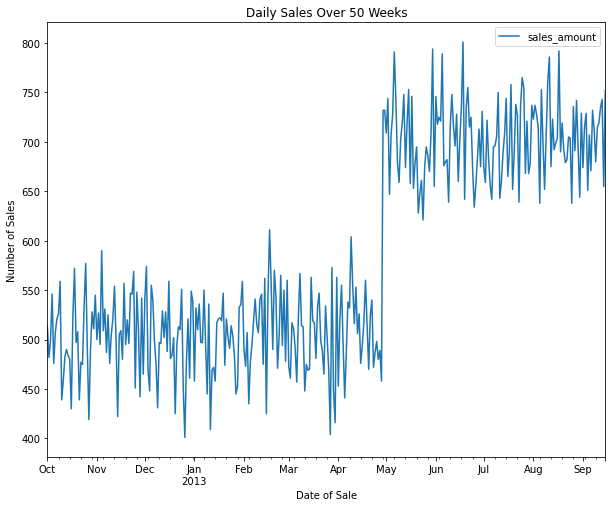

In [77]:
# Set constant figure size
figure_size = (10,8)
# Plot daily sales for all 50 weeks
daily_sales_df.plot(figsize=figure_size, title="Daily Sales Over 50 Weeks", ylabel="Number of Sales", xlabel="Date of Sale")
plt.savefig('./resources/daily_sales.png')
plt.show()

# Question 2: What Date Did the Change in Sales Occur?

In [78]:
# Create a column to hold sales amount from prior day
daily_sales_df['sales_amount_prev_day'] = [None] + daily_sales_df['sales_amount'].to_list()[:-1]

# Compare sales amount difference with sales from the previous day
daily_sales_df["difference_in_sales"] = daily_sales_df['sales_amount'] - daily_sales_df['sales_amount_prev_day']
daily_sales_df.head()

,sales_amount,sales_amount_prev_day,difference_in_sales
sale_time,,,
2012-10-01,514,NaN,NaN
2012-10-02,482,514.0,-32.0
2012-10-03,499,482.0,17.0
2012-10-04,546,499.0,47.0
2012-10-05,476,546.0,-70.0


In [79]:
# Return the index of the first occurence of  
sales_change = daily_sales_df['difference_in_sales'].idxmax()
print(sales_change)

2013-04-29 00:00:00


In [98]:
# Display the date and data from the day with the biggest change in sales
daily_sales_df[daily_sales_df.index == sales_change]

,sales_amount,sales_amount_prev_day,difference_in_sales
sale_time,,,
2013-04-29,732,458.0,274.0


<Figure size 432x288 with 0 Axes>

# Question 3: Is the Drop in Sales Statistically Significantly Lower?

In [81]:
# Check for null values
daily_sales_df.isnull().sum()

sales_amount             0
sales_amount_prev_day    1
difference_in_sales      1
dtype: int64

In [82]:
# Compare maximum sales amount with sales_amount
stats.ttest_1samp(daily_sales_df['sales_amount'], 732, nan_policy='omit')

Ttest_1sampResult(statistic=-26.367553024439697, pvalue=4.5681432390066193e-85)

The p-value is 4.56*10^-85 indicating that the change in sales is highly statistically significant

# Question 4: Is the Drop in Sales Due to a Change in the Gender of the Customers?

In [83]:
# Change sale_time to datetime dtype
df['sale_day'] = pd.to_datetime(df['sale_time']).dt.floor('d')

# Create gender_df to explore distribution of purchases by gender each day
gender_df = df.groupby(['sale_day', 'purchaser_gender']).size().reset_index(name='sales_amount')

In [84]:
gender_df.head()

,sale_day,purchaser_gender,sales_amount
0,2012-10-01,female,413
1,2012-10-01,male,101
2,2012-10-02,female,379
3,2012-10-02,male,103
4,2012-10-03,female,386


In [85]:
# Create a new dataframe with only unique sales times
new_df = pd.DataFrame(gender_df['sale_day'].unique(), columns=['sale_day'])

# Calculate female and male sales amount separately
new_df['female_sales'] = pd.Series(gender_df[gender_df.purchaser_gender == 'female']['sales_amount']).reset_index(drop=True)
new_df['male_sales'] = pd.Series(gender_df[gender_df.purchaser_gender == 'male']['sales_amount']).reset_index(drop=True)

new_df 

,sale_day,female_sales,male_sales
0,2012-10-01,413,101
1,2012-10-02,379,103
2,2012-10-03,386,113
3,2012-10-04,432,114
4,2012-10-05,368,108
...,...,...,...
345,2013-09-11,224,495
346,2013-09-12,225,510
347,2013-09-13,206,537
348,2013-09-14,193,462


In [86]:
# Calculate the ratio of sales based on gender
new_df['gender_ratio'] =new_df['male_sales']/new_df['female_sales']
new_df

,sale_day,female_sales,male_sales,gender_ratio
0,2012-10-01,413,101,0.244552
1,2012-10-02,379,103,0.271768
2,2012-10-03,386,113,0.292746
3,2012-10-04,432,114,0.263889
4,2012-10-05,368,108,0.293478
...,...,...,...,...
345,2013-09-11,224,495,2.209821
346,2013-09-12,225,510,2.266667
347,2013-09-13,206,537,2.606796
348,2013-09-14,193,462,2.393782


In [87]:
# Prepare dataframe for plot
plot_df = new_df.copy()
plot_df['total_sales_amount'] = plot_df['female_sales'] + plot_df['male_sales']
plot_df.index = plot_df['sale_day']
plot_df.drop(columns=['gender_ratio', 'sale_day'], inplace=True)
plot_df

,female_sales,male_sales,total_sales_amount
sale_day,,,
2012-10-01,413,101,514
2012-10-02,379,103,482
2012-10-03,386,113,499
2012-10-04,432,114,546
2012-10-05,368,108,476
...,...,...,...
2013-09-11,224,495,719
2013-09-12,225,510,735
2013-09-13,206,537,743


<function matplotlib.pyplot.show(*args, **kw)>

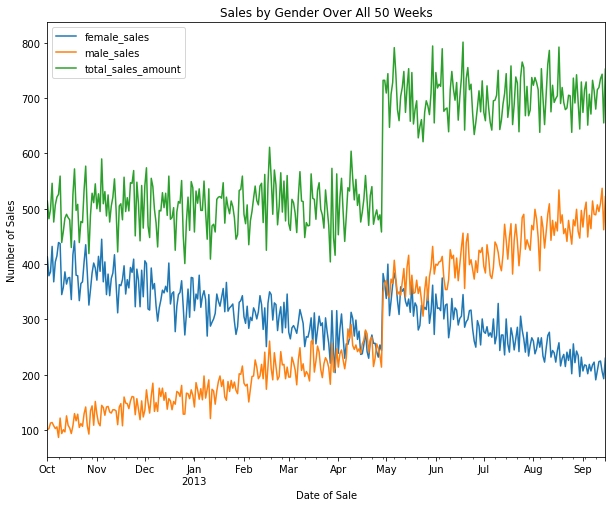

In [88]:
plot_df.plot(figsize=figure_size, ylabel="Number of Sales", xlabel="Date of Sale", title="Sales by Gender Over All 50 Weeks")
plt.savefig('./resources/gender_sales.png')
plt.show

# Question 5: What is the Percentage of Sales in Each Part of the Day Over All 50 Weeks?

In [89]:
# Extract hours from the sale_time
df['sale_hour'] = pd.to_datetime(df['sale_time']).dt.ceil('h').dt.hour
df.dtypes

sale_time           datetime64[ns]
purchaser_gender            object
sale_day            datetime64[ns]
sale_hour                    int64
dtype: object

In [90]:
df['sale_hour'].value_counts()

15    13856
14    13801
16    13751
13    13441
17    13270
12    13040
18    12412
11    11886
19    11651
10    11228
20    10032
9      9938
8      9073
21     8486
7      7708
22     6739
6      6247
5      4943
23     4203
4      3521
3      2284
0      1506
2      1045
1       268
Name: sale_hour, dtype: int64

In [91]:
# Define a function that creates "time of day" logic
def time_of_day(sale_hour):
    '''Assign labels based on the hour the sale occurred'''
    if sale_hour >= 0 and sale_hour <= 6:
        return 'night'
    if sale_hour >= 6 and sale_hour <= 12:
        return 'morning'
    if sale_hour >=12 and sale_hour <= 18:
        return 'afternoon'
    if sale_hour >=18 and sale_hour <= 24:
        return 'evening'

In [92]:
# Apply function to create time of day column in dataframe
df['day_part'] = df['sale_hour'].apply(time_of_day)
df.head()

,sale_time,purchaser_gender,sale_day,sale_hour,day_part
0,2013-01-07 02:14:07,female,2013-01-07,3,night
1,2013-01-07 02:57:53,male,2013-01-07,3,night
2,2013-01-07 02:59:49,female,2013-01-07,3,night
3,2013-01-07 03:02:53,male,2013-01-07,4,night
4,2013-01-07 03:27:36,female,2013-01-07,4,night


In [93]:
# Drop unnecessary columns
df = df.drop(columns=['sale_time', 'purchaser_gender', 'sale_day'])
df.head(25)

,sale_hour,day_part
0,3,night
1,3,night
2,3,night
3,4,night
4,4,night
5,4,night
6,4,night
7,5,night
8,5,night
9,5,night


In [94]:
# Calculate the sales amount based on time of day
tod_df = df.groupby(df.day_part).size().reset_index(name='sales_amount_day_part')

tod_df.head()

,day_part,sales_amount_day_part
0,afternoon,80531
1,evening,41111
2,morning,62873
3,night,19814


In [95]:
# Calculate the percentage of sales based on time of day
tod_df['prct_sales_day_part'] = (tod_df['sales_amount_day_part'] / tod_df['sales_amount_day_part'].sum()) * 100

tod_df

,day_part,sales_amount_day_part,prct_sales_day_part
0,afternoon,80531,39.412418
1,evening,41111,20.120003
2,morning,62873,30.770473
3,night,19814,9.697106
